In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.color import gray2rgb
from torchvision.ops import nms
from pytorch_toolbelt.utils import to_numpy
from dotenv import load_dotenv


from src.visualization import tensor_to_image

current_dir = Path(".")
load_dotenv()
current_dir.absolute()

PosixPath('/workspaces/sartorius_instance_segmentation')

In [2]:
# Global config of configuration
test_images_dir = Path(os.environ['dataset_path']) / "test"
weights_dir = current_dir / "weights" / "maxim_baseline.ckpt"
device = "cpu"

# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.1  # Overlapping instances will be dropped, lower - lower overlap is permitted
mask_threshold = 0.5  # Cut masks by the threshold

In [3]:
assert test_images_dir.is_dir(), f"Check test dir path for correctness, was looking at {test_images_dir.absolute()}"
assert weights_dir.is_file(), f"File not found, was looking at {weights_dir.absolute()}"

In [4]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

/data/kaggle_data/test/7ae19de7bc2a.png


/conda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


found 100 instances!
After mask thresholding survived 100 instances
After confidence thresholding survived 100 instances
Finally survived 92 instances! Displaying them...


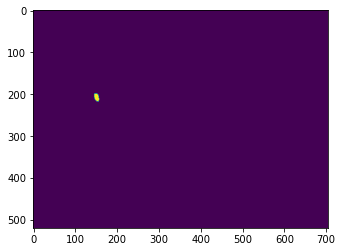

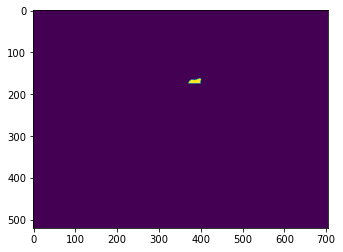

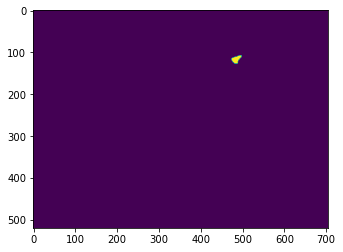

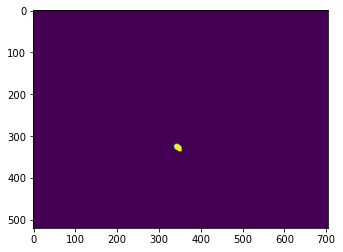

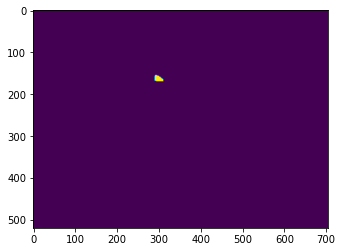

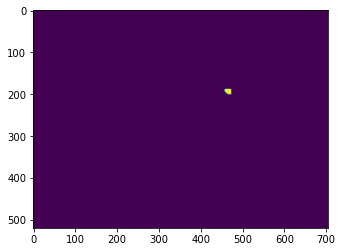

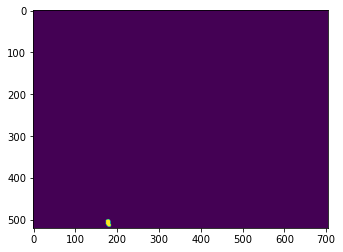

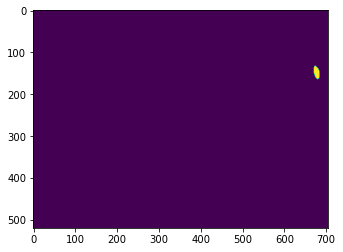

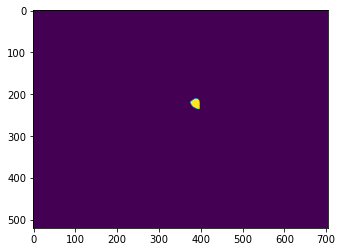

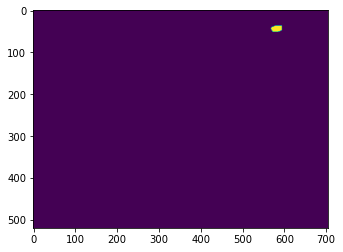

In [5]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model.eval()

for image_path in test_images_dir.glob("**/*.png"):
    print(image_path.absolute())
    image = io.imread(str(image_path))
    image = preprocess_image(image=image)['image']
    image = image.to(device)
    
    with torch.no_grad():
        output = model.forward([image])[0]

    scores = output['scores'].detach().cpu()
    masks = output['masks'].squeeze().detach().cpu()
    boxes = output['boxes'].detach().cpu()

    print(f"found {len(boxes)} instances!")

    masks = (masks >= mask_threshold).int()

    # Now some masks can be empty (all zeros), we need to exclude them
    indices = torch.as_tensor([torch.sum(mask) > 0 for mask in masks])
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"After mask thresholding survived {len(masks)} instances")

    indices = scores >= score_threshold
    masks, boxes, scores = masks[indices], boxes[indices], scores

    print(f"After confidence thresholding survived {len(masks)} instances")

    indices = nms(boxes, scores, nms_threshold)
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    print(f"Finally survived {len(masks)} instances! Displaying them...") 

    # Display masks
    for ii in range(10):
        plt.imshow(masks[ii])
        plt.show()

    break
